In [1]:
%load_ext autoreload
%autoreload 2

# Experimental demonstration of memory-enhanced quantum communication

[This paper](https://arxiv.org/abs/1909.01323) (PDF in current folder)

<center><img src="figure_1.png"/></center>

2021-04-01 18:46:50,032 - qm - INFO - Performing health check
2021-04-01 18:46:50,035 - qm - INFO - Health check passed
2021-04-01 18:46:50,244 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 18:46:50,260 - qm - INFO - Flags: 
2021-04-01 18:46:50,260 - qm - INFO - Simulating Qua program


C:\Users\gal\Google Drive\qua-libs\examples\Workshops\CQE\8.memory-enhanced-quantum-comms\qua_macros.py:21: QMDeprecationWarning: _TimeTagging.raw is deprecated since 0.8: use time_tagging.analog instead
  measure('readout', 'readout1', None, time_tagging.raw(result1, meas_len, targetLen=resultLen1))
C:\Users\gal\Google Drive\qua-libs\examples\Workshops\CQE\8.memory-enhanced-quantum-comms\qua_macros.py:22: QMDeprecationWarning: _TimeTagging.raw is deprecated since 0.8: use time_tagging.analog instead
  measure('readout', 'readout2', None, time_tagging.raw(result2, meas_len, targetLen=resultLen2))
<ipython-input-4-db79774f2076>:61: QMDeprecationWarning: _TimeTagging.raw is deprecated since 0.8: use time_tagging.analog instead
  measure('readout', 'readout1', None, time_tagging.raw(result1, meas_len, targetLen=resultLen1))
<ipython-input-4-db79774f2076>:62: QMDeprecationWarning: _TimeTagging.raw is deprecated since 0.8: use time_tagging.analog instead
  measure('readout', 'readout2', Non

Text(0, 0.5, 'counting')

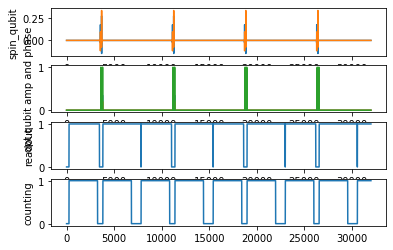

In [4]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
from Configuration import config

import matplotlib.pyplot as plt


#############
# Time trace:
#############
from qua_macros import reset_spin

meas_len = 1e3
rep_num = 1e7
threshold = 7
Qmm = QuantumMachinesManager()
Qmm.close_all_quantum_machines()
qm = Qmm.open_qm(config)
with program() as spin_qubit_spec:

    ##############################
    # Declare real-time variables:
    ##############################

    n = declare(int)
    k = declare(int)
    se = declare(bool)

    result1 = declare(int, size=int(meas_len / 500))
    resultLen1 = declare(int)
    result2 = declare(int, size=int(meas_len / 500))
    resultLen2 = declare(int)

    ###############
    # The sequence:
    ###############
    with for_(n, 0, n < rep_num, n + 1):

        reset_spin(threshold)

        # sequence:
        play('pi2', 'spin_qubit')
        align('spin_qubit', 'opt_qubit_amp')

        play('photon', 'opt_qubit_amp')
        wait(32, 'opt_qubit_amp')
        align('opt_qubit_amp', 'opt_qubit_phase')
        play('phase_shift', 'opt_qubit_phase')
        play('photon', 'opt_qubit_amp')

        wait(18, 'spin_qubit')
        play('pi', 'spin_qubit')
        # align('spin_qubit', 'opt_qubit_amp', 'opt_qubit_phase')



        # Readout:
        align('opt_qubit_amp', 'opt_qubit_phase', 'readout', 'readout1', 'readout2')
        play('on', 'readout', duration=1000)
        measure('readout', 'readout1', None, time_tagging.raw(result1, meas_len, targetLen=resultLen1))
        measure('readout', 'readout2', None, time_tagging.raw(result2, meas_len, targetLen=resultLen2))
        # measure_spin('z', threshold, se)

        # save
        i = declare(int)
        j = declare(int)
        with for_(i, 0, i < resultLen1, i + 1):
            save(result1[i], 'time_tags_plus')
        with for_(j, 0, j < resultLen2, j + 1):
            save(result2[j], 'time_tags_plus')

job = qm.simulate(spin_qubit_spec, SimulationConfig(8000))
# job.get_simulated_samples().con1.plot()

sim = job.get_simulated_samples()
pulses = job.simulated_analog_waveforms()
dig_pulses = job.simulated_digital_waveforms()


plt.figure(1)
ax1 = plt.subplot(411)
plt.plot(sim.con1.analog['1'])
plt.plot(sim.con1.analog['2'])
plt.ylabel('spin_qubit')

plt.subplot(412)
plt.plot(sim.con1.analog['3'])
plt.plot(sim.con1.analog['4'])
plt.plot(sim.con1.digital['3'])
plt.ylabel('opt qubit amp and phase')

plt.subplot(413)
plt.plot(sim.con1.digital['1'])
plt.ylabel('readout')

plt.subplot(414)
plt.plot(sim.con1.digital['7'])
# plt.plot(sim.con1.digital['8'])
plt.ylabel('counting')

